In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Batting Analysis (Ball By Ball)/EDA/Batting Performance Metrics.csv')
scaled_df = pd.read_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Batting Analysis (Ball By Ball)/EDA/Batsman Performance Metrics (Scaled).csv')

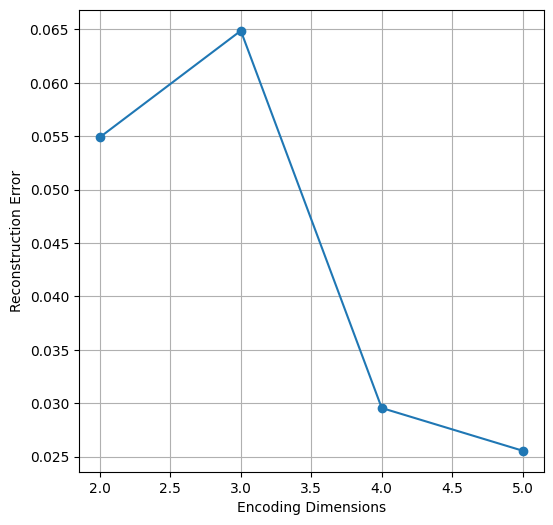

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(scaled_df, test_size=0.2, random_state=42)

encoding_dims = range(2,6)
reconstruction_errors = []

for dim in encoding_dims:
  input_dim = scaled_df.shape[1]
  input_layer = Input(shape=(input_dim,))
  encoder = Dense(dim, activation='relu')(input_layer)
  decoder = Dense(input_dim, activation='linear')(encoder)
  autoencoder = Model(input_layer, decoder)

  autoencoder.compile(optimizer='adam', loss='mean_squared_error')
  autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test), verbose=0)

  reconstruction_error = autoencoder.evaluate(X_test, X_test, verbose=0)
  reconstruction_errors.append(reconstruction_error)

plt.figure(figsize=(6, 6))
plt.plot(encoding_dims, reconstruction_errors, marker='o')
plt.xlabel('Encoding Dimensions')
plt.ylabel('Reconstruction Error')
# plt.title('Reconstruction Error vs. Encoding Dimensions')
plt.grid(True)
plt.show()

In [ ]:
optimal_dim = encoding_dims[np.argmin(reconstruction_errors)]
print(optimal_dim)

5


In [ ]:
n_features = scaled_df.shape[1]
n_features

9

In [ ]:
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_layer = Input(shape=(n_features,))
encoder = Dense(n_features-1)(input_layer)
encoder = LeakyReLU()(encoder)
encoder = Dense(n_features-1)(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dense(n_features-1)(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dense(optimal_dim)(encoder)

decoder = Dense(n_features+1)(encoder)
decoder = LeakyReLU()(decoder)
decoder = Dense(n_features+1)(decoder)
decoder = LeakyReLU()(decoder)
decoder = Dense(n_features+1)(decoder)
decoder = LeakyReLU()(decoder)
decoder = Dense(n_features, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
encoder = Model(inputs=input_layer, outputs=encoder)
autoencoder.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

autoencoder.fit(scaled_df, scaled_df, epochs=100, batch_size=15, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

encoded_data = encoder.predict(scaled_df)

encoded_df = pd.DataFrame(encoded_data, columns=[f'ED {i+1}' for i in range(optimal_dim)])

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2597 - val_loss: 0.2313 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2151 - val_loss: 0.1884 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1716 - val_loss: 0.1348 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1192 - val_loss: 0.0880 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0799 - val_loss: 0.0642 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0587 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0417 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0342 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0276 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 10/100
12/12

In [ ]:
encoded_df.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Batting Analysis (Ball By Ball)/Analysis (Autoencoders)/Batsman Performance Metrics (Encoded).csv', index=False)

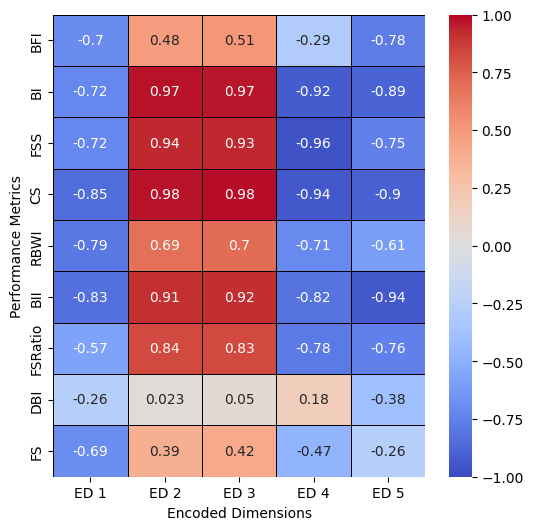

In [ ]:
correlation_matrix = scaled_df.corrwith(encoded_df, axis=0).to_frame().transpose()

# Transpose the correlation matrix for better readability
correlation_matrix = pd.concat([scaled_df.corrwith(encoded_df[col]) for col in encoded_df.columns], axis=1)
correlation_matrix.columns = encoded_df.columns

plt.figure(figsize=(6, 6))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0, linecolor='black', linewidths=0.5)


# plt.title('Correlation Between Scaled Performance Metrics and Encoded Dimensions')
plt.xlabel('Encoded Dimensions')
plt.ylabel('Performance Metrics')

plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

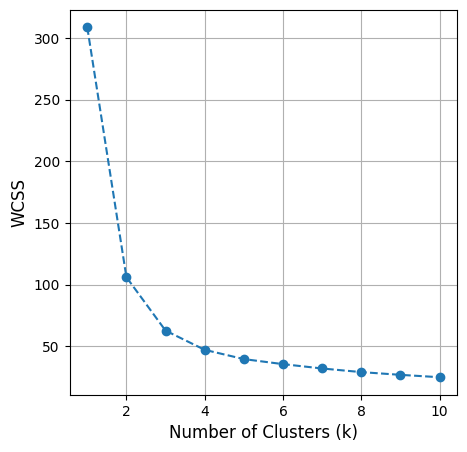

In [ ]:
from sklearn.cluster import KMeans

wcss = []
k_values = range(1,11)

for k in k_values:
  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
  kmeans.fit(encoded_df)
  wcss.append(kmeans.inertia_)

plt.figure(figsize=(5, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
# plt.title('Optimal Number of Clusters', fontsize=14)
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

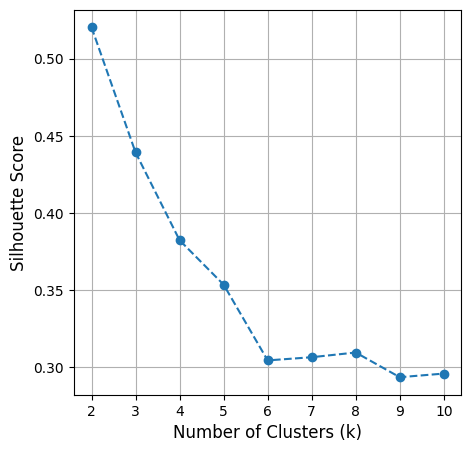

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in k_values[1:]:
  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
  kmeans.fit(encoded_df)
  score = silhouette_score(encoded_df, kmeans.labels_)
  sil_scores.append(score)

plt.figure(figsize=(5, 5))
plt.plot(k_values[1:], sil_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
# plt.title('Optimal Number of Clusters', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(encoded_df)


encoded_df['KCluster'] = clusters
df['KCluster'] = clusters
scaled_df['KCluster'] = clusters



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


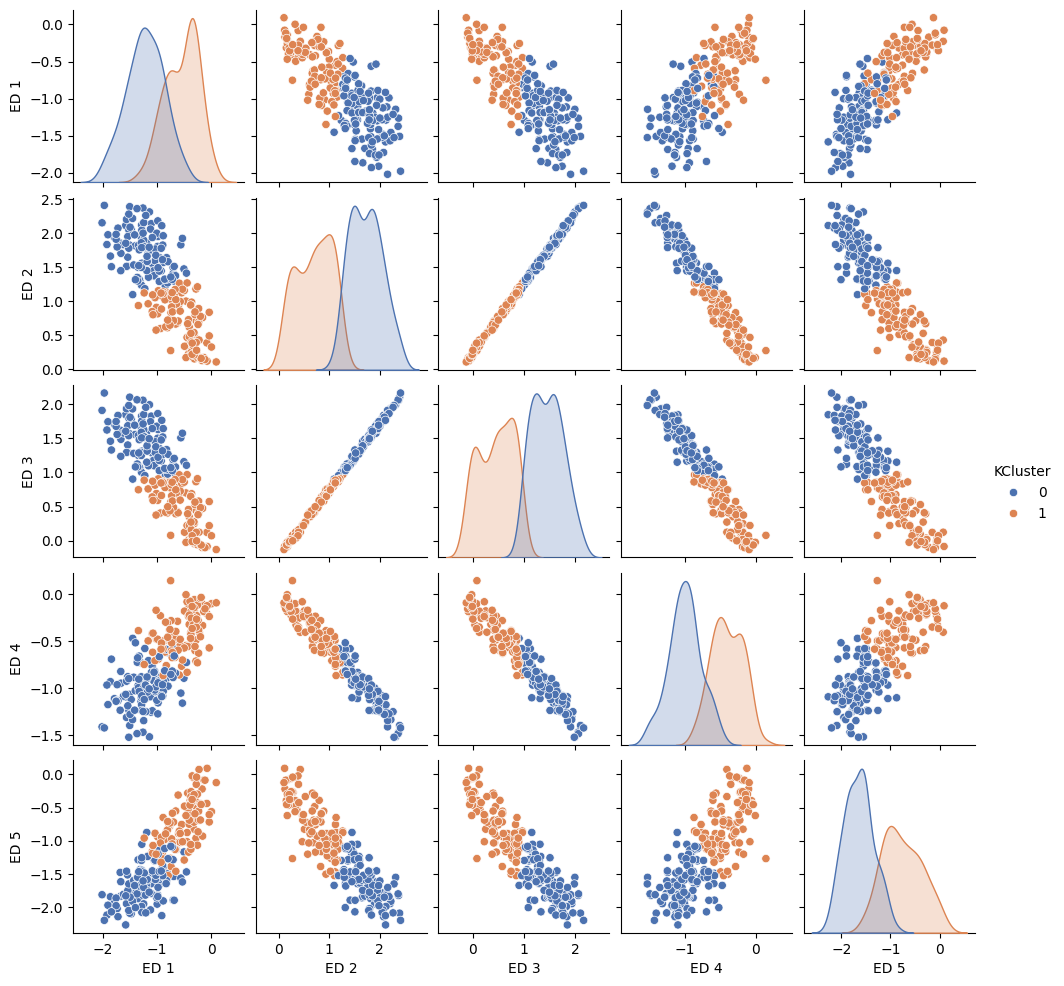

In [ ]:
sns.pairplot(encoded_df, hue='KCluster', palette='deep', diag_kind='kde', height=2, aspect=1)
# plt.suptitle('Pairplot of Encoded Dimensions', y=1.02)
plt.show()

In [ ]:
kcluster_means_summary = scaled_df.groupby('KCluster').mean()
kcluster_means_summary.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Batting Analysis (Ball By Ball)/Analysis (Autoencoders)/KMeans Cluster Summary (Autoencoder).csv', index=False)
kcluster_means_summary

,BFI,BI,FSS,CS,RBWI,BII,FSRatio,DBI,FS
KCluster,,,,,,,,,
0,0.510611,0.740751,0.632623,0.705634,0.634168,0.703895,0.409953,0.47895,0.510193
1,0.341269,0.292510,0.308804,0.268986,0.367343,0.233299,0.098047,0.45617,0.323558


In [ ]:
kcluster_descriptive = scaled_df.groupby('KCluster').describe()
kcluster_descriptive.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Batting Analysis (Ball By Ball)/Analysis (Autoencoders)/KMeans Cluster Descriptive (Autoencoder).csv')
kcluster_descriptive

BFI                                                              \
          count      mean       std       min       25%       50%       75%   
KCluster                                                                      
0         117.0  0.510611  0.156407  0.132887  0.402178  0.522257  0.602975   
1         105.0  0.341269  0.156210  0.000000  0.238790  0.326831  0.413749   

                       BI            ...       DBI               FS            \
               max  count      mean  ...       75%       max  count      mean   
KCluster                             ...                                        
0         1.000000  117.0  0.740751  ...  0.570712  1.000000  117.0  0.510193   
1         0.797838  105.0  0.292510  ...  0.537920  0.860375  105.0  0.323558   

                                                                 
               std  min       25%       50%       75%       max  
KCluster                                                         
0         0.250571  0.0  0.368152  0.555127  0.668954  1.000000  
1         0.254545  0.0  0.000000  0.300802  0.555127  0.923279  

[2 rows x 72 columns]

In [ ]:
weights = {
    'BFI': 0.10,
    'BI': 1,
    'FSS': 1,
    'CS': 1,
    'RBWI': 0.10,
    'FSRatio': 0.5,
    'BII': 1,
    'DBI': 1,
    'FS': 1
}

cluster_0_data = scaled_df[clusters == 0].copy()


cluster_0_data['Composite Score'] = (
    cluster_0_data['BFI'] * weights['BFI'] +
    cluster_0_data['BI'] * weights['BI'] +
    cluster_0_data['BII'] * weights['BII'] +
    cluster_0_data['CS'] * weights['CS'] +
    cluster_0_data['FSS'] * weights['FSS'] +
    cluster_0_data['RBWI'] * weights['RBWI'] +
    cluster_0_data['FSRatio'] * weights['FSRatio'] +
    cluster_0_data['DBI'] * weights['DBI'] +
    cluster_0_data['FS'] * weights['FS']
)


cluster_0_data['Batsman'] = df[clusters == 0]['Player'].values
cluster_0_data['Team'] = df[clusters == 0]['Team'].values


ranked_kcluster = cluster_0_data[['Batsman', 'Team', 'Composite Score']].sort_values(by='Composite Score', ascending=False)


ranked_kcluster


,Batsman,Team,Composite Score
188,C Dyer,Littletown CC Under 13,5.799060
88,Oliver Jackson,Castle Eden CC Under 13,5.593234
108,O Henderson,Chester Le Street CC Under 13,5.455711
137,Oliver Jackson,Durham City CC Under 13 Blue,5.338377
126,K Russell,Easington C.W. CC Under 13,5.291774
...,...,...,...
165,Gemma Potts,Sunderland CC Under 13,2.991539
150,Chloe Lucas,Seaham Harbour CC Under 13 Purple,2.940111
45,Thom Burnham,"Brandon CC, Durham Under 13",2.920571
216,Athena Whiteley,Ryhope CC Under 13,2.917159


In [ ]:
ranked_kcluster['Rank'] = range(1, len(ranked_kcluster) + 1)
ranked_kcluster = ranked_kcluster[['Rank', 'Batsman', 'Team', 'Composite Score']]
ranked_kcluster


,Rank,Batsman,Team,Composite Score
188,1,C Dyer,Littletown CC Under 13,5.799060
88,2,Oliver Jackson,Castle Eden CC Under 13,5.593234
108,3,O Henderson,Chester Le Street CC Under 13,5.455711
137,4,Oliver Jackson,Durham City CC Under 13 Blue,5.338377
126,5,K Russell,Easington C.W. CC Under 13,5.291774
...,...,...,...,...
165,113,Gemma Potts,Sunderland CC Under 13,2.991539
150,114,Chloe Lucas,Seaham Harbour CC Under 13 Purple,2.940111
45,115,Thom Burnham,"Brandon CC, Durham Under 13",2.920571
216,116,Athena Whiteley,Ryhope CC Under 13,2.917159


In [ ]:
ranked_kcluster.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Batting Analysis (Ball By Ball)/Analysis (Autoencoders)/Batsman Ranking KMeans (Autoencoder).csv', index=False)

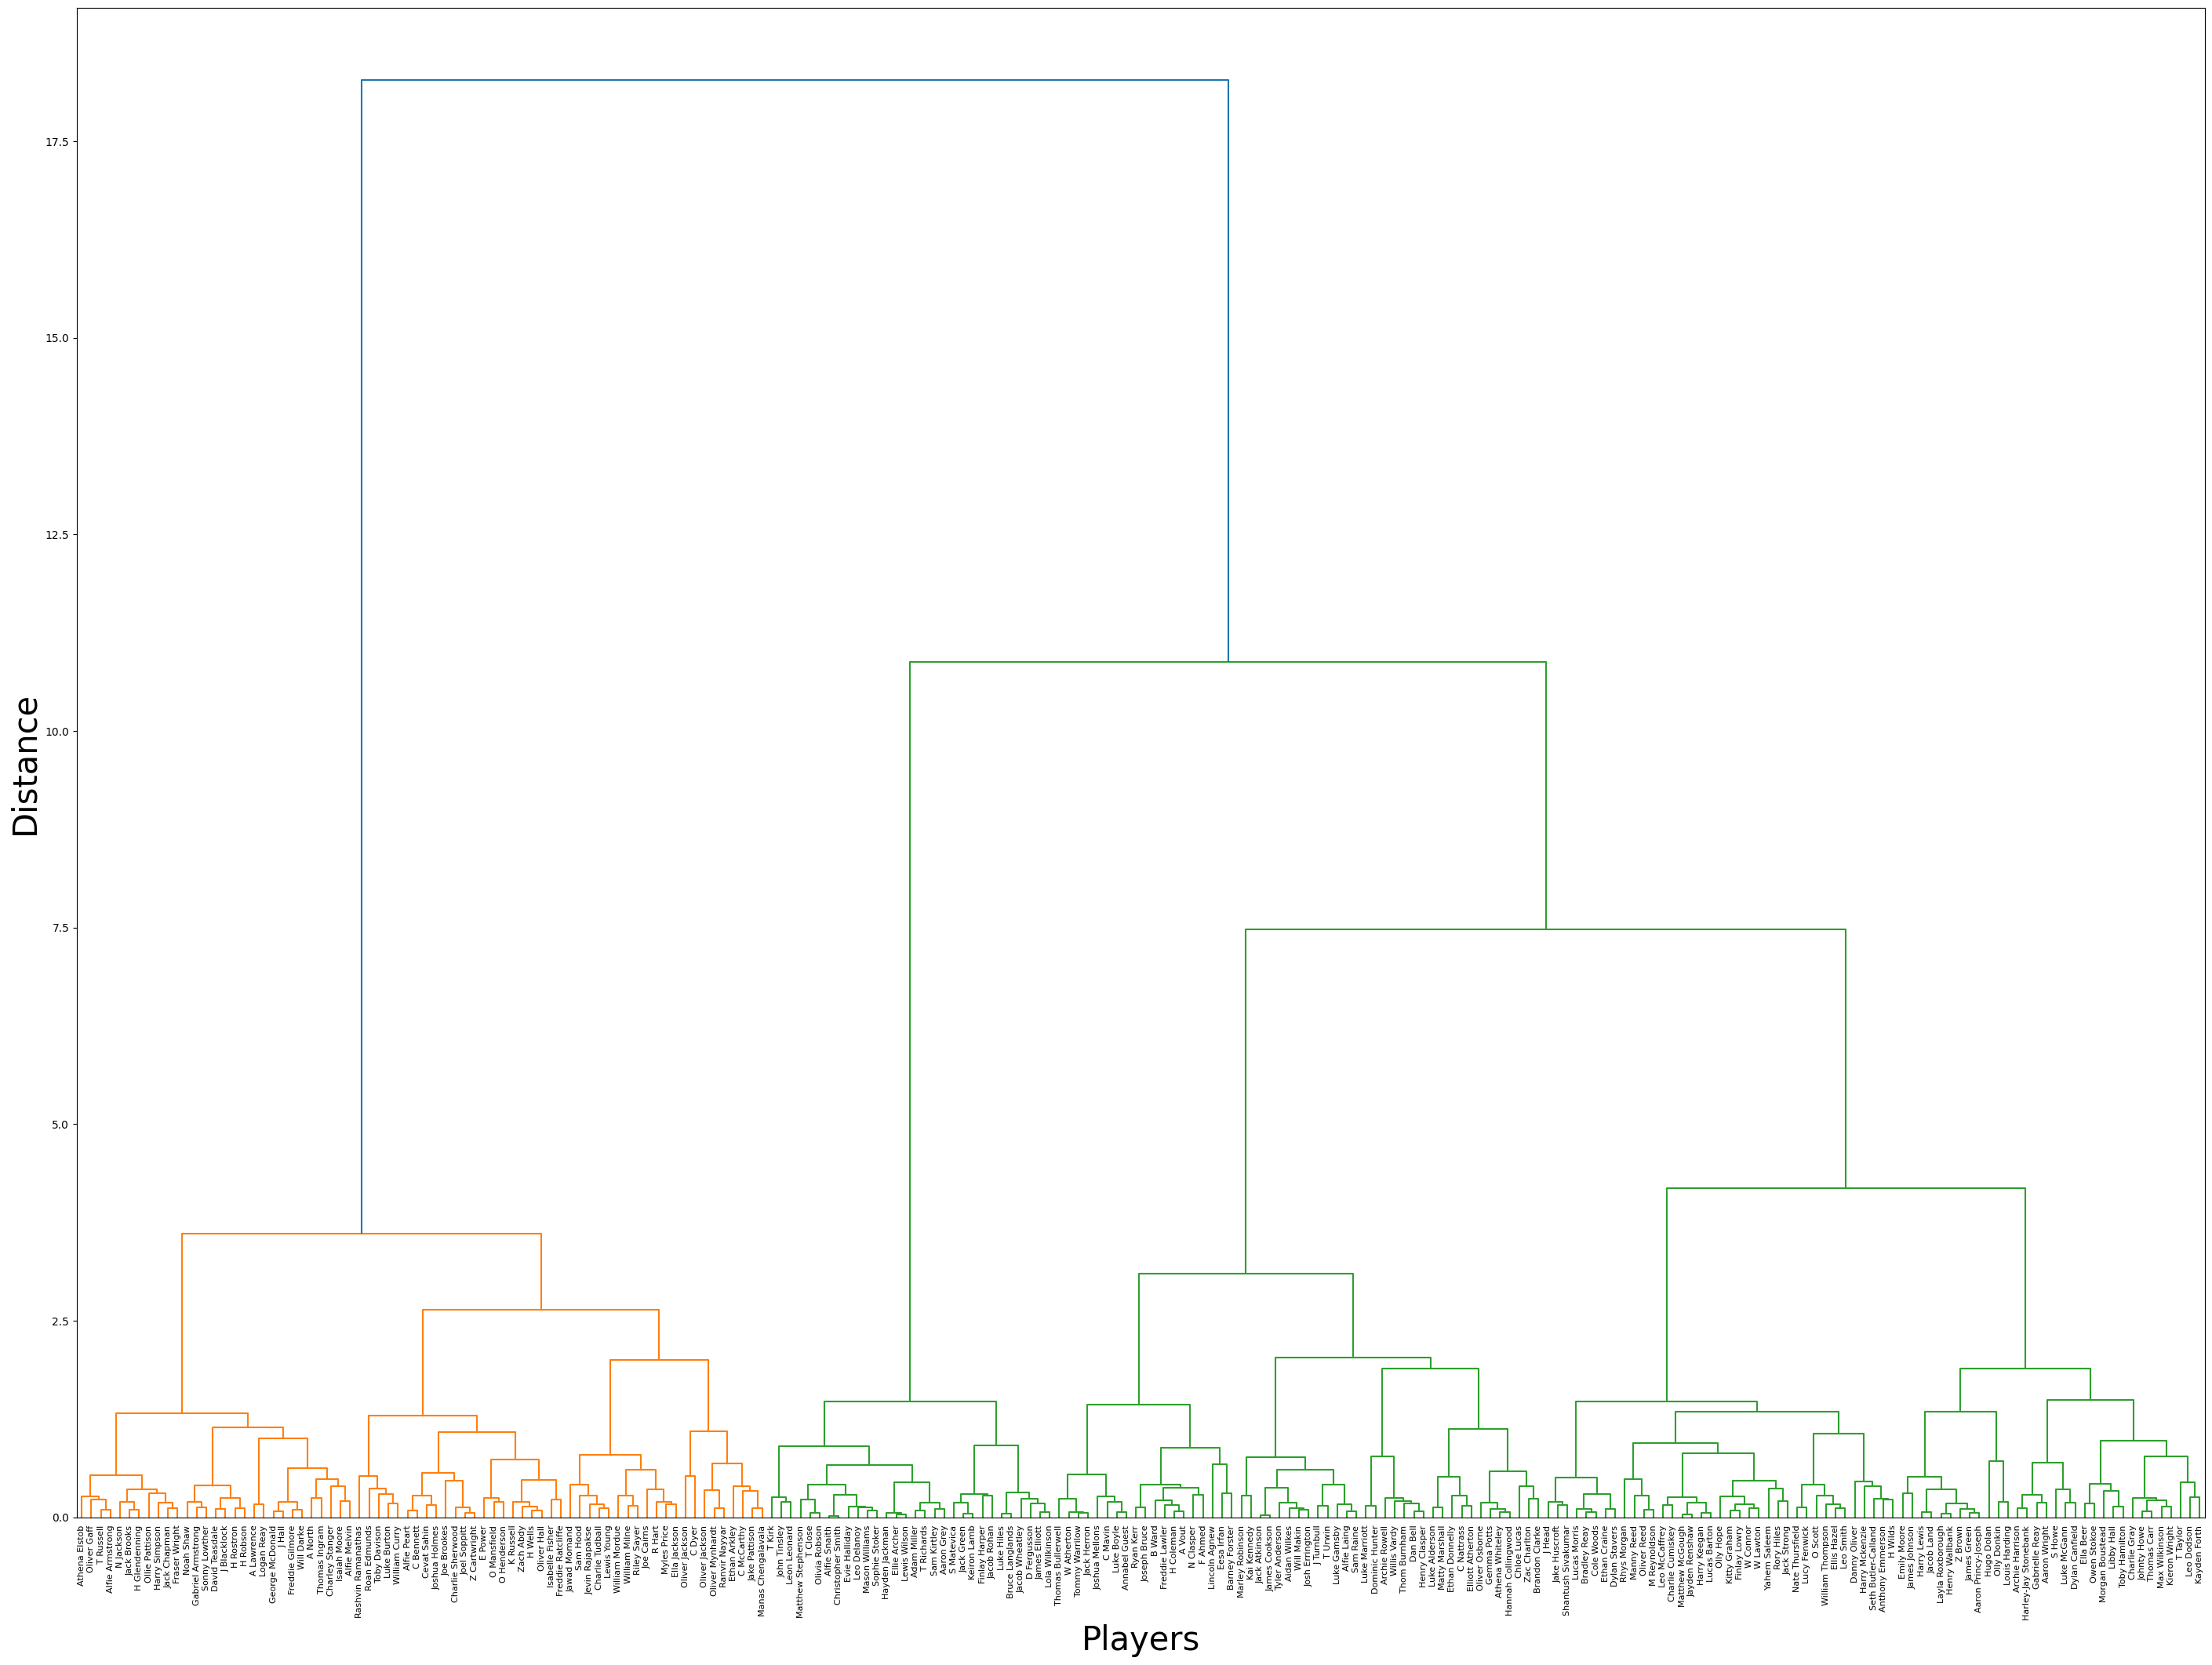

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

h_linkage = linkage(encoded_df.drop('KCluster', axis=1), method='ward')

plt.figure(figsize=(35,25))
dendrogram(h_linkage, labels=df['Player'].values, leaf_rotation=90, leaf_font_size=8)
# plt.title('Hierarchical Clustering Dendrgram', fontsize=25)
plt.xlabel('Players', fontsize=30)
plt.ylabel('Distance', fontsize=30)

plt.show()

In [ ]:
h_labels = fcluster(h_linkage, t=12, criterion='distance')

df['Hcluster'] = h_labels
scaled_df['Hcluster'] = h_labels
encoded_df['Hcluster'] = h_labels


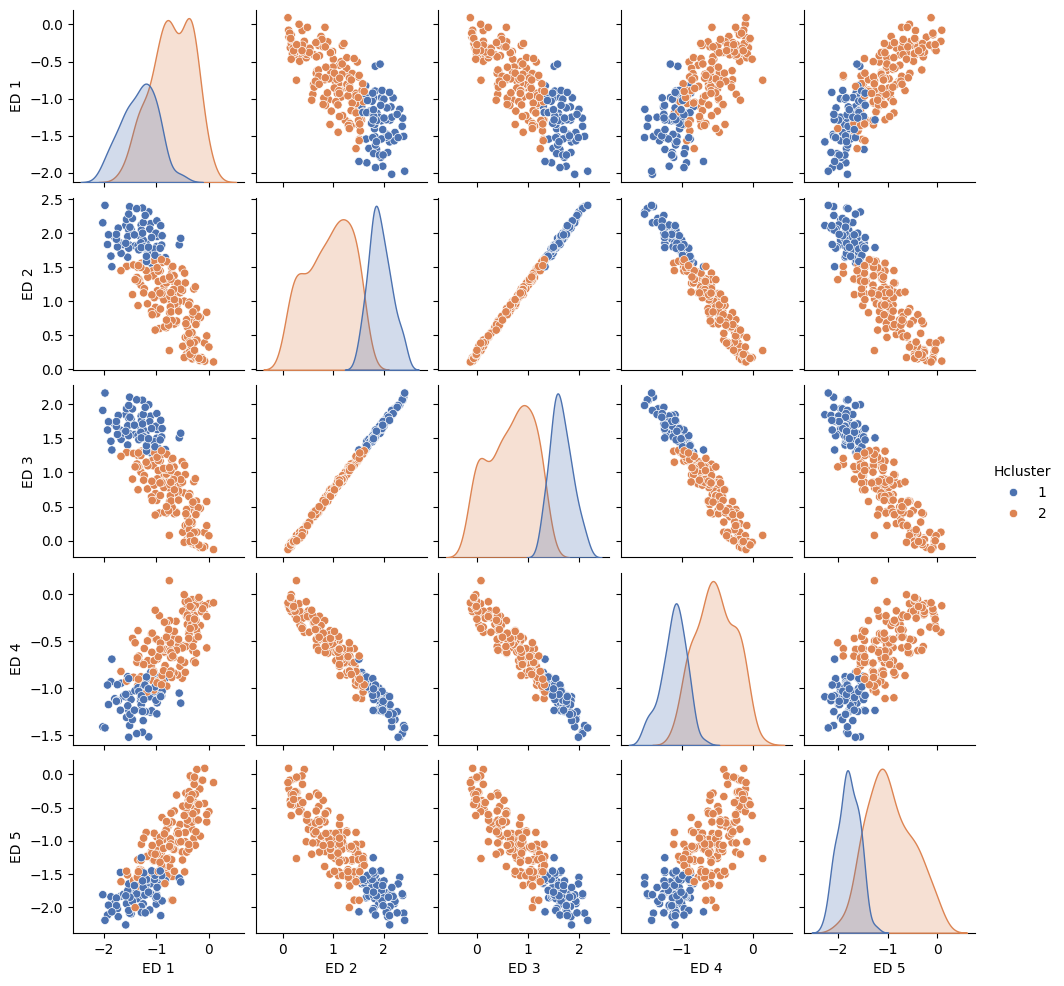

In [ ]:
sns.pairplot(encoded_df.drop('KCluster', axis=1), hue='Hcluster', palette='deep', diag_kind='kde', height=2, aspect=1)
# plt.suptitle('Pairplot of Encoded Dimensions', y=1.02, fontsize=16)
plt.show()


In [ ]:
hcluster_means_summary = scaled_df.drop('KCluster',axis=1).groupby('Hcluster').mean()
hcluster_means_summary.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Batting Analysis (Ball By Ball)/Analysis (Autoencoders)/Hierarchical Cluster Summary (Autoencoder).csv', index=False)
hcluster_means_summary

,BFI,BI,FSS,CS,RBWI,BII,FSRatio,DBI,FS
Hcluster,,,,,,,,,
1,0.548161,0.826543,0.685115,0.780906,0.647665,0.785490,0.484590,0.494934,0.562335
2,0.374048,0.385802,0.380753,0.363850,0.440912,0.335312,0.155794,0.455332,0.354521


In [ ]:
hcluster_descriptive = scaled_df.drop('KCluster',axis=1).groupby('Hcluster').describe()
hcluster_descriptive.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Batting Analysis (Ball By Ball)/Analysis (Autoencoders)/Hierarchical Cluster Descriptive (Autoencoder).csv')
hcluster_descriptive

BFI                                                             \
          count      mean       std      min       25%       50%       75%   
Hcluster                                                                     
1          72.0  0.548161  0.136244  0.24611  0.449966  0.545174  0.629568   
2         150.0  0.374048  0.167285  0.00000  0.269230  0.346104  0.502632   

                       BI            ...       DBI              FS            \
               max  count      mean  ...       75%      max  count      mean   
Hcluster                             ...                                       
1         1.000000   72.0  0.826543  ...  0.566902  1.00000   72.0  0.562335   
2         0.836327  150.0  0.385802  ...  0.548024  0.87461  150.0  0.354521   

                                                                 
               std  min       25%       50%       75%       max  
Hcluster                                                         
1         0.239786  0.0  0.414611  0.588491  0.683967  1.000000  
2         0.256014  0.0  0.200835  0.368152  0.555127  0.923279  

[2 rows x 72 columns]

In [ ]:
h_cluster_1_data = scaled_df.drop('KCluster', axis=1)[h_labels == 1].copy()

h_cluster_1_data['Composite Score'] = (
    h_cluster_1_data['BFI'] * weights['BFI'] +
    h_cluster_1_data['BI'] * weights['BI'] +
    h_cluster_1_data['BII'] * weights['BII'] +
    h_cluster_1_data['CS'] * weights['CS'] +
    h_cluster_1_data['FSS'] * weights['FSS'] +
    h_cluster_1_data['RBWI'] * weights['RBWI'] +
    h_cluster_1_data['FSRatio'] * weights['FSRatio'] +
    h_cluster_1_data['DBI'] * weights['DBI'] +
    h_cluster_1_data['FS'] * weights['FS']
)


h_cluster_1_data['Batsman'] = df[h_labels==1]['Player'].values
h_cluster_1_data['Team'] = df[h_labels == 1]['Team'].values


ranked_hcluster = h_cluster_1_data[['Batsman', 'Team', 'Composite Score']].sort_values(by='Composite Score', ascending=False)


ranked_hcluster

,Batsman,Team,Composite Score
188,C Dyer,Littletown CC Under 13,5.799060
88,Oliver Jackson,Castle Eden CC Under 13,5.593234
108,O Henderson,Chester Le Street CC Under 13,5.455711
137,Oliver Jackson,Durham City CC Under 13 Blue,5.338377
126,K Russell,Easington C.W. CC Under 13,5.291774
...,...,...,...
86,H Robson,Castle Eden CC Under 13,3.698383
7,Noah Shaw,Beamish and E. Stanley CC Under 13,3.696106
141,J Blacklock,Durham City CC Under 13 Gold,3.662795
124,J Hall,Easington C.W. CC Under 13,3.660290


In [ ]:
ranked_hcluster['Rank'] = range(1, len(ranked_hcluster) + 1)
ranked_hcluster = ranked_hcluster[['Rank', 'Batsman', 'Team', 'Composite Score']]
ranked_hcluster

,Rank,Batsman,Team,Composite Score
188,1,C Dyer,Littletown CC Under 13,5.799060
88,2,Oliver Jackson,Castle Eden CC Under 13,5.593234
108,3,O Henderson,Chester Le Street CC Under 13,5.455711
137,4,Oliver Jackson,Durham City CC Under 13 Blue,5.338377
126,5,K Russell,Easington C.W. CC Under 13,5.291774
...,...,...,...,...
86,68,H Robson,Castle Eden CC Under 13,3.698383
7,69,Noah Shaw,Beamish and E. Stanley CC Under 13,3.696106
141,70,J Blacklock,Durham City CC Under 13 Gold,3.662795
124,71,J Hall,Easington C.W. CC Under 13,3.660290


In [ ]:
ranked_hcluster.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Batting Analysis (Ball By Ball)/Analysis (Autoencoders)/Batsman Ranking Hierarchical (Autoencoder).csv', index=False)

In [ ]:
df.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Batting Analysis (Ball By Ball)/Analysis (Autoencoders)/Batting Performance Metrics with clusters (Autoencoder).csv', index=False)
encoded_df.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Batting Analysis (Ball By Ball)/Analysis (Autoencoders)/Encoded Batting Performance Metrics with clusters (Autoencoder).csv', index=False)
scaled_df.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Batting Analysis (Ball By Ball)/Analysis (Autoencoders)/Scaled Batting Performance Metrics with clusters (Autoencoder).csv', index = False)